In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential, load_model, Model
from keras.layers import BatchNormalization, LSTM, Dense, Activation, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
    # Transform time-series data into supervised learning data.
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def build_lstm_model(train_X):
    if len(train_X.shape) < 3:
        raise BaseException("Seems that your data is not prepared for a lstm training, please check it out.")
    model = Sequential()
    model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[
        2])))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1024))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200))
    model.add(Dense(1))  # 定义输出层神经元个数为1个，即输出只有1维
    model.add(Activation('elu'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    model.summary()
    # model.add(Activation('sigmoid'))#根据情况添加激活函数
    return model

In [18]:
PATH = './all_data.csv'
aqi_data = pd.read_csv(PATH)
aqi_data = aqi_data.drop(['Unnamed: 0', 'date'], axis=1)
feature_columns = aqi_data.columns
target_columns = ['AQI', 'PM2_5', 'PM_10', 'SO2', 'NO2', 'O3', 'CO']
aqi_data_supervised = series_to_supervised(aqi_data, 12, 12, True)
X = aqi_data_supervised[aqi_data_supervised.columns[0: feature_columns.__len__() * 12]]
aqi_data_y = series_to_supervised(aqi_data[target_columns], 12, 12, True)
y = aqi_data_y[aqi_data_y.columns[target_columns.__len__() * 18:target_columns.__len__() * 18 + 1]]
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.9, shuffle=False)
# # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
sample = train_X[0:1].values.reshape((-1, 12, feature_columns.__len__()))

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_X)
test_X = scaler_X.transform(test_X)
train_y = scaler_y.fit_transform(train_y)
test_y = scaler_y.transform(test_y)
train_X = train_X.reshape((-1, 12, 20))
test_X = test_X.reshape((-1, 12, 20))
model = build_lstm_model(train_X)
model.fit(train_X, train_y, batch_size=2048, epochs=50)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               283648    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 2048)             

array([[0.09254815],
       [0.09405542],
       [0.09516595],
       ...,
       [0.20647201],
       [0.1895709 ],
       [0.17577675]], dtype=float32)

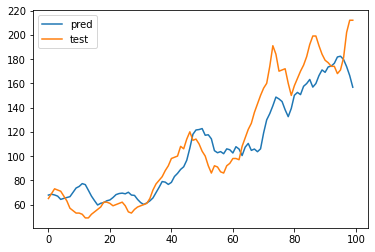

In [19]:
test_X = test_X.reshape((-1, 12, 20))
pred = model.predict(test_X)
import matplotlib.pyplot as plt
pred = scaler_y.inverse_transform(pred)

plt.plot(pred[0:100])
plt.plot(scaler_y.inverse_transform(test_y[0:100]))
plt.legend(['pred', 'test'])
plt.show()
